# imports

In [1]:
!pip install conllu
from conllu import parse

In [2]:
from gensim.models import Word2Vec
import numpy as np


In [3]:
import numpy as np
from sklearn.metrics import accuracy_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn.utils.rnn import pad_sequence

## mount a drive


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Load the Data

In [13]:
train_path = '/content/drive/MyDrive/IIIT/SEM 4/NLP/A2/dataset/english/UD_English-Atis/en_atis-ud-train.conllu'
test_path = '/content/drive/MyDrive/IIIT/SEM 4/NLP/A2/dataset/english/UD_English-Atis/en_atis-ud-test.conllu'
dev_path = '/content/drive/MyDrive/IIIT/SEM 4/NLP/A2/dataset/english/UD_English-Atis/en_atis-ud-dev.conllu'
conllu_data = None

with open(train_path, 'r', encoding='utf-8') as f:
    conllu_data = f.read()

train_sentences = parse(conllu_data)

with open(test_path, 'r', encoding='utf-8') as f:
    conllu_data = f.read()

test_sentences = parse(conllu_data)

with open(dev_path, 'r', encoding='utf-8') as f:
    conllu_data = f.read()

dev_sentences = parse(conllu_data)



In [14]:
word_to_ix = dict()
tag_to_ix = dict()

In [15]:
freq_map = dict()

for sentence in train_sentences:
  for token in sentence:
    if token['form'] not in freq_map:
      freq_map[token['form']] = 1
    else :
      freq_map[token['form']] += 1


one_freq_word = list()

for item,freq in freq_map.items():
  if freq == 1:
    one_freq_word.append(item)

In [16]:
len(one_freq_word)

263

In [17]:
len(freq_map)

863

In [18]:
unknown  = "<UNK>"

In [19]:
for sentence in train_sentences:
  for token in sentence:
    if token['upos'] == "SYM" :
      continue
    if token['form'] not in word_to_ix:
      if token['form'] not in one_freq_word:
        word_to_ix[token['form']] = len(word_to_ix)
    if token['upos'] not in tag_to_ix:
      tag_to_ix[token['upos']] = len(tag_to_ix)

word_to_ix[unknown] = len(word_to_ix)

# for sentence in test_sentences:
#   for token in sentence:
#     if token['upos'] == "SYM" :
#       continue
#     if token['form'] not in word_to_ix:
#       word_to_ix[token['form']] = len(word_to_ix)
#     if token['upos'] not in tag_to_ix:
#       tag_to_ix[token['upos']] = len(tag_to_ix)

# for sentence in dev_sentences:
#   for token in sentence:
#     if token['upos'] == "SYM" :
#       continue
#     if token['form'] not in word_to_ix:
#       word_to_ix[token['form']] = len(word_to_ix)
#     if token['upos'] not in tag_to_ix:
#       tag_to_ix[token['upos']] = len(tag_to_ix)

In [20]:
word_to_ix['SOS'] = len(word_to_ix)
word_to_ix['EOS'] = len(word_to_ix)

In [21]:
tag_to_ix = {
              'PRON': 0,
              'AUX': 1,
              'DET': 2,
              'NOUN': 3,
              'ADP': 4,
              'PROPN': 5,
              'VERB': 6,
              'NUM': 7,
              'ADJ': 8,
              'CCONJ': 9,
              'ADV': 10,
              'PART': 11,
              'INTJ': 12
            }

In [22]:
train_s = []
train_label = []
for sentence in train_sentences:
  temp = [  ]
  for token in sentence:
    if token['upos'] == "SYM" :
      continue
    if token['form'] in freq_map :
      if freq_map[token['form']] == 1 :
        temp.append(unknown)
      else:
        temp.append(token['form'])
    else:
      temp.append(unknown)
    train_label.append(token['upos'])
  train_s.append(temp)

dev_s = []
dev_label = []
for sentence in dev_sentences:
  temp = [  ]
  for token in sentence:
    if token['upos'] == "SYM" :
      continue
    if token['form'] in freq_map :
      if freq_map[token['form']] == 1 :
        temp.append(unknown)
      else:
        temp.append(token['form'])
    else:
      temp.append(unknown)
    dev_label.append(token['upos'])
  dev_s.append(temp)

test_s = []
test_label = []
for sentence in test_sentences:
  temp = [  ]
  for token in sentence:
    if token['upos'] == "SYM" :
      continue
    if token['form'] in freq_map :
      if freq_map[token['form']] == 1 :
        temp.append(unknown)
      else:
        temp.append(token['form'])
    else:
      temp.append(unknown)
    test_label.append(token['upos'])
  test_s.append(temp)

# Helper Functions

### Plotting and testing

In [23]:

def plot_accuracy(epochs,acc,text):
    plt.rcParams["figure.figsize"] = [6, 4]
    plt.plot(epochs, acc, marker=".", markersize=5, markeredgecolor="blue", markerfacecolor="lightyellow")
    plt.title(f'epoch vs Accuracy({text})',fontsize=14)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')


def plot_loss(epochs,train_l,test_l,text):
  plt.rcParams["figure.figsize"] = [6, 4]
  plt.rcParams["figure.autolayout"] = True
  plt.plot(epochs, train_l, marker=".", markeredgecolor="blue", markerfacecolor="lightyellow",label='line1')
  plt.plot(epochs, test_l, marker=".", markeredgecolor="red", markerfacecolor="lightyellow",label='line2')
  plt.title(f'Loss vs Epoch({text})',fontsize=14)
  plt.xlabel('Epochs')
  plt.ylabel('Loss')

In [24]:
def evaluate_classification(y_true, y_pred):
    # Calculate accuracy
    accuracy = accuracy_score(y_true, y_pred)

    # Calculate recall
    recall = recall_score(y_true, y_pred, average='micro')

    # Calculate F1 score
    f1_micro = f1_score(y_true, y_pred, average='micro')
    f1_macro = f1_score(y_true, y_pred, average='macro')

    # Calculate confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    print("Accuracy:", accuracy)
    print("Recall (micro):", recall)
    print("F1 Score (micro):", f1_micro)
    print("F1 Score (macro):", f1_macro)

    plt.figure(figsize=(7, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(13), yticklabels=range(13))
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()
    # return accuracy, recall, f1_micro, f1_macro, cm

In [25]:
def tets_on(test_data,test_label,model,batch_size,word_to_ix,tag_to_ix):
  pred_label = []
  actual_label = []
  with torch.no_grad():
    for i in range(0, len(test_data), batch_size):
      sentences = test_data[i:i+batch_size]
      tags_list = test_label[i:i+batch_size]

      input_seqs = [torch.tensor([word_to_ix[word] for word in sentence], dtype=torch.long) for sentence in sentences]
      targets = [torch.tensor([tag_to_ix[tag]], dtype=torch.long) for tag in tags_list]

      padded_batch = pad_sequence(input_seqs, batch_first=True)
      outputs = model(padded_batch)

      max_indices = torch.argmax(outputs, dim=1)

      pred_label.extend(max_indices)
      actual_label.extend(targets)

  return actual_label,pred_label

### Tarining

In [26]:
def prepare_windows(sentences,n,p):
  train_data = []
  for sentence in sentences:
    k = len(sentence)
    temp = [ 'SOS' for i in range(p)]
    temp.extend(sentence)
    temp.extend(["EOS" for i in range(n)])

    for i in range(k):
      train_data.append(temp[i:(i + n+p+1)])

  return train_data

In [27]:
def train_the_model(model, loss_function, optimizer,train_data,train_label,word_to_ix,tag_to_ix,dev_data,dev_label ,epochs):

  train_loss_6 = []
  test_loss_6 = []
  accuracies_6 = []
  for epoch in range(epochs):

    model.train()
    train_loss_epoch = []
    test_loss_epoch = []

    for i in range(0, len(train_data), batch_size):
      sentences = train_data[i:i+batch_size]
      tags_list = train_label[i:i+batch_size]


      input_seqs = [torch.tensor([word_to_ix[word] for word in sentence], dtype=torch.long) for sentence in sentences]
      targets = [torch.tensor([tag_to_ix[tag]], dtype=torch.long) for tag in tags_list]

      padded_batch = pad_sequence(input_seqs, batch_first=True)

      optimizer.zero_grad()
      outputs = model(padded_batch)

      total_loss = 0

      for output, target in zip(outputs, targets):
            loss = loss_function(output.view(-1, tagset_size), target)
            total_loss += loss

      total_loss.backward()
      optimizer.step()
      train_loss_epoch.append(total_loss.item())


    print(epoch+1,end=" ")

    model.eval()
    tot = 0
    corr = 0
    with torch.no_grad():
      for i in range(0, len(dev_data), batch_size):
        sentences = dev_data[i:i+batch_size]
        tags_list = dev_label[i:i+batch_size]

        input_seqs = [torch.tensor([word_to_ix[word] for word in sentence], dtype=torch.long) for sentence in sentences]
        targets = [torch.tensor([tag_to_ix[tag]], dtype=torch.long) for tag in tags_list]

        padded_batch = pad_sequence(input_seqs, batch_first=True)


        outputs = model(padded_batch)

        max_indices = torch.argmax(outputs, dim=1)


        total_loss_t = 0

        for output, target in zip(outputs, targets):
              loss = loss_function(output.view(-1, tagset_size), target)
              total_loss_t += loss

        test_loss_epoch.append(total_loss_t.item())

        for ind in range(len(max_indices)):
          if max_indices[ind] == targets[ind]:
            corr += 1
        tot += len(max_indices)

    # # Epoch wise loss and accuracies are stored
    train_loss_6.append(np.mean(train_loss_epoch))
    test_loss_6.append(np.mean(test_loss_epoch))
    accuracy = 100*corr/tot
    accuracies_6.append(accuracy)
    print(np.mean(train_loss_epoch), np.mean(test_loss_epoch), end=" ")
    print(accuracy)

  return train_loss_6, test_loss_6, accuracies_6, model


# N=3 and P=2 Configurations

### data preparation


In [98]:
n=3
p=2

In [99]:
train_data = prepare_windows(train_s,n,p)
dev_data = prepare_windows(dev_s,n,p)
test_data = prepare_windows(test_s,n,p)

## Relu

### Class Model

In [30]:
class SimpleMLEModel(nn.Module):
    def __init__(self, vocab_size, tagset_size,sen_size, embedding_dim, hidden_dim):
        super(SimpleMLEModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.hidden_dim = hidden_dim
        self.linear1 = nn.Linear(embedding_dim*sen_size, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, tagset_size)
        self.relu = nn.ReLU()

    def forward(self, sentence):
      embeds = self.embedding(sentence)
      embeds = torch.flatten(embeds, start_dim=1)
      # print(embeds.shape)
      out = self.linear1(embeds)
      out = self.relu(out)
      out = self.linear2(out)
      return out

In [31]:
class SimpleMLEModel2(nn.Module):
    def __init__(self, vocab_size, tagset_size,sen_size, embedding_dim, hidden_dim1, hidden_dim2):
        super(SimpleMLEModel2, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.hidden_dim = hidden_dim
        self.linear1 = nn.Linear(embedding_dim*sen_size, hidden_dim1)
        self.linear2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.linear3 = nn.Linear(hidden_dim2, tagset_size)
        self.relu = nn.ReLU()

    def forward(self, sentence):
      embeds = self.embedding(sentence)
      embeds = torch.flatten(embeds, start_dim=1)
      # print(embeds.shape)
      out = self.linear1(embeds)
      out = self.relu(out)
      out = self.linear2(out)
      out = self.relu(out)
      out = self.linear3(out)
      return out

### Config1

In [32]:
vocab_size = len(word_to_ix)
tagset_size = len(tag_to_ix)
embedding_dim = 25
hidden_dim = 25
learning_rate = 0.01
epochs = 15
batch_size = 1

In [33]:
model = SimpleMLEModel(vocab_size,tagset_size,n+p+1, embedding_dim, hidden_dim)

loss_function = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

In [34]:
train_loss_6 = []
test_loss_6 = []
accuracies_6 = []

In [35]:
for epoch in range(10):

  model.train()
  train_loss_epoch = []
  test_loss_epoch = []

  for i in range(0, len(train_data), batch_size):
    sentences = train_data[i:i+batch_size]
    tags_list = train_label[i:i+batch_size]


    input_seqs = [torch.tensor([word_to_ix[word] for word in sentence], dtype=torch.long) for sentence in sentences]
    targets = [torch.tensor([tag_to_ix[tag]], dtype=torch.long) for tag in tags_list]

    padded_batch = pad_sequence(input_seqs, batch_first=True)

    optimizer.zero_grad()
    outputs = model(padded_batch)

    total_loss = 0

    for output, target in zip(outputs, targets):
          loss = loss_function(output.view(-1, tagset_size), target)
          total_loss += loss

    total_loss.backward()
    optimizer.step()
    train_loss_epoch.append(total_loss.item())


  print(epoch+1,end=" ")

  model.eval()
  tot = 0
  corr = 0
  with torch.no_grad():
    for i in range(0, len(dev_data), batch_size):
      sentences = dev_data[i:i+batch_size]
      tags_list = dev_label[i:i+batch_size]

      input_seqs = [torch.tensor([word_to_ix[word] for word in sentence], dtype=torch.long) for sentence in sentences]
      targets = [torch.tensor([tag_to_ix[tag]], dtype=torch.long) for tag in tags_list]

      padded_batch = pad_sequence(input_seqs, batch_first=True)


      outputs = model(padded_batch)

      max_indices = torch.argmax(outputs, dim=1)


      total_loss_t = 0

      for output, target in zip(outputs, targets):
            loss = loss_function(output.view(-1, tagset_size), target)
            total_loss_t += loss

      test_loss_epoch.append(total_loss_t.item())

      for ind in range(len(max_indices)):
        if max_indices[ind] == targets[ind]:
          corr += 1
      tot += len(max_indices)

  # # Epoch wise loss and accuracies are stored
  train_loss_6.append(np.mean(train_loss_epoch))
  test_loss_6.append(np.mean(test_loss_epoch))
  accuracy = 100*corr/tot
  accuracies_6.append(accuracy)
  print(np.mean(train_loss_epoch), np.mean(test_loss_epoch), end=" ")
  print(accuracy)

1 0.35159573102711156 0.4176667475941891 87.88015657934358
2 0.17883866390555153 0.290847275353045 91.38813610358326
3 0.12888690050813797 0.2264273668797815 93.01415236374586
4 0.1013627579466846 0.19479155813838644 93.84221619993977
5 0.08406061057098115 0.17991465856292607 94.20355314664258
6 0.07072748509755977 0.168710784300265 94.5046672688949
7 0.06060080282219201 0.16596177266117562 94.83589280337247
8 0.05230157492319018 0.16132724732914266 94.82083709725985
9 0.046149921288804505 0.16083722520877106 95.3026196928636
10 0.04145418385214433 0.16289063328286912 95.27250828063836


In [36]:
accuracies_6

[87.88015657934358,
 91.38813610358326,
 93.01415236374586,
 93.84221619993977,
 94.20355314664258,
 94.5046672688949,
 94.83589280337247,
 94.82083709725985,
 95.3026196928636,
 95.27250828063836]

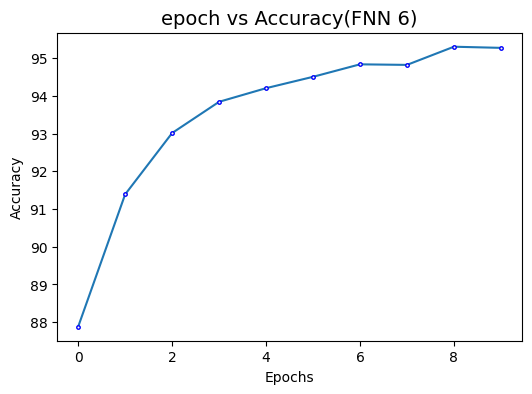

In [37]:
epochs = [ i for i in range(10)]
plot_accuracy(epochs,accuracies_6,'FNN 6')

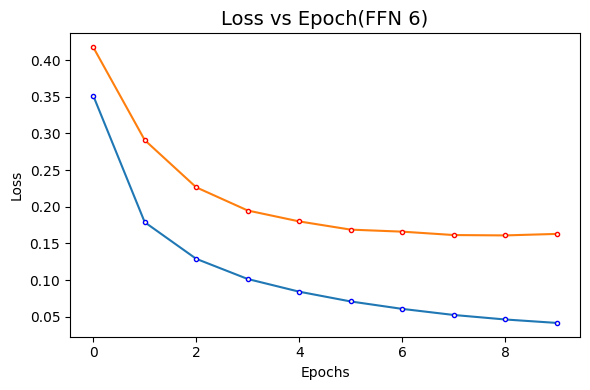

In [39]:
epochs = [ i for i in range(10)]
plot_loss(epochs,train_loss_6,test_loss_6,'FFN 6')

In [40]:
torch.save(model.state_dict(), '/content/drive/MyDrive/IIIT/SEM 4/NLP/A2/dataset/english/models/fnn_config_new1.pth')

Accuracy: 0.9527250828063836
Recall (micro): 0.9527250828063836
F1 Score (micro): 0.9527250828063836
F1 Score (macro): 0.9151149041068556


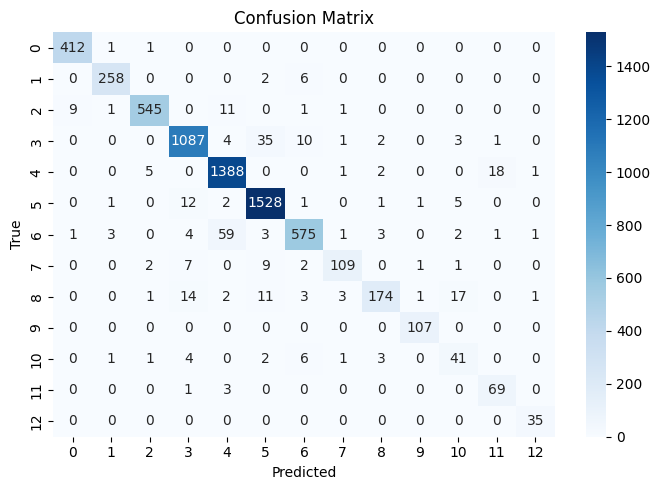

In [41]:
actual_label, pred_label = tets_on(dev_data,dev_label,model,batch_size,word_to_ix,tag_to_ix)
evaluate_classification(actual_label, pred_label)

Accuracy: 0.9559270516717325
Recall (micro): 0.9559270516717325
F1 Score (micro): 0.9559270516717325
F1 Score (macro): 0.9263278231722973


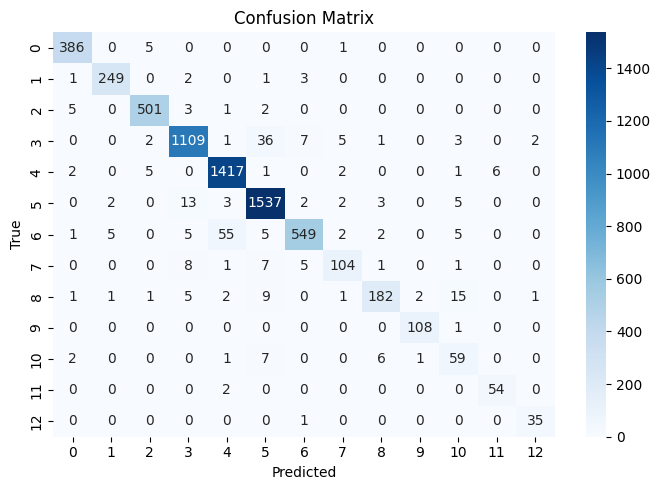

In [42]:
actual_label, pred_label = tets_on(test_data,test_label,model,batch_size,word_to_ix,tag_to_ix)
evaluate_classification(actual_label, pred_label)

### config 2

In [100]:
vocab_size = len(word_to_ix)
tagset_size = len(tag_to_ix)
embedding_dim = 100
hidden_dim = 25
learning_rate = 0.01
batch_size = 1

In [101]:
model2 = SimpleMLEModel(vocab_size,tagset_size,n+p+1, embedding_dim, hidden_dim)

loss_function = nn.CrossEntropyLoss()
optimizer = optim.SGD(model2.parameters(), lr=learning_rate)

In [102]:
train_loss_7,test_loss_7,accuracies_7, model2 = train_the_model(model2, loss_function, optimizer,train_data,train_label,word_to_ix,tag_to_ix,dev_data,dev_label,10 )

1 0.2152129546420217 0.24173622411110116 92.83348389039446
2 0.10375450663739634 0.18956865475085657 94.38422161999398
3 0.06901586530149958 0.16962274110358502 95.16711833785004
4 0.05057329636334855 0.16600114881486513 95.52845528455285
5 0.04233868842809624 0.16376683179974325 95.39295392953929
6 0.03686824371266584 0.16115013006800663 95.9349593495935
7 0.030697278376978575 0.18014064895696238 95.81451370069256
8 0.031128498254440303 0.17300287947207038 96.04034929238182
9 0.025506076366734905 0.1692626837029869 96.0252935862692
10 0.025393293421665436 0.1859759532315098 95.88979223125564


In [103]:
accuracies_7

[92.83348389039446,
 94.38422161999398,
 95.16711833785004,
 95.52845528455285,
 95.39295392953929,
 95.9349593495935,
 95.81451370069256,
 96.04034929238182,
 96.0252935862692,
 95.88979223125564]

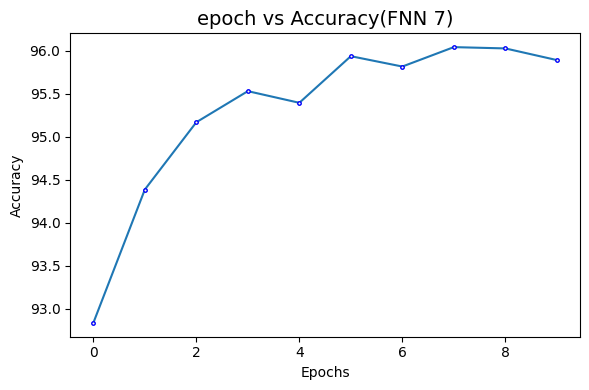

In [104]:
epochs = [ i for i in range(10)]
plot_accuracy(epochs,accuracies_7,'FNN 7')

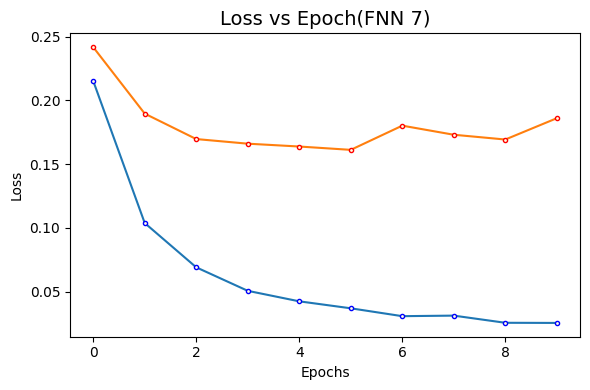

In [105]:
epochs = [ i for i in range(10)]
plot_loss(epochs,train_loss_7,test_loss_7,'FNN 7')

In [106]:
torch.save(model2.state_dict(), '/content/drive/MyDrive/IIIT/SEM 4/NLP/A2/dataset/english/models/fnn_config_new2.pth')

Accuracy: 0.9588979223125564
Recall (micro): 0.9588979223125564
F1 Score (micro): 0.9588979223125564
F1 Score (macro): 0.9315474532645684


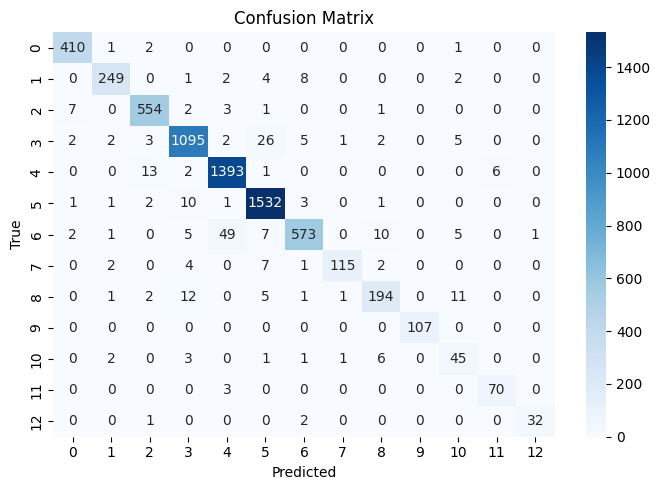

In [107]:
actual_label, pred_label = tets_on(dev_data,dev_label,model2,batch_size,word_to_ix,tag_to_ix)
evaluate_classification(actual_label, pred_label)

Accuracy: 0.955775075987842
Recall (micro): 0.955775075987842
F1 Score (micro): 0.955775075987842
F1 Score (macro): 0.9333712148598946


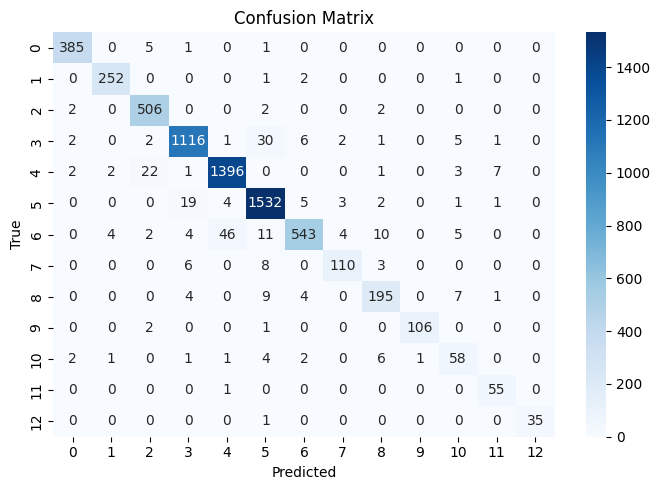

In [108]:
actual_label, pred_label = tets_on(test_data,test_label,model2,batch_size,word_to_ix,tag_to_ix)
evaluate_classification(actual_label, pred_label)

### config 3

In [109]:
vocab_size = len(word_to_ix)
tagset_size = len(tag_to_ix)
embedding_dim = 25
hidden_dim1 = 25
hidden_dim2 = 100
learning_rate = 0.01
batch_size = 1

In [110]:
model3 = SimpleMLEModel2(vocab_size,tagset_size,n+p+1, embedding_dim, hidden_dim1,hidden_dim2)

loss_function = nn.CrossEntropyLoss()
optimizer = optim.SGD(model3.parameters(), lr=learning_rate)

In [111]:
train_loss_8,test_loss_8,accuracies_8, model3 = train_the_model(model3, loss_function, optimizer,train_data,train_label,word_to_ix,tag_to_ix,dev_data,dev_label,7 )

1 0.34523432330054227 0.3929086833258229 89.17494730502861
2 0.15761478428097275 0.2632187524146424 92.63775971093044
3 0.11195853428234047 0.2113281141557653 93.87232761216501
4 0.08465474803718274 0.2067582824727742 94.65522433002108
5 0.06978534756112116 0.18808304126726766 94.98644986449864
6 0.05971008821982778 0.18252045074519202 95.28756398675098
7 0.053213971165001706 0.16600897645177773 95.63384522734117


In [113]:
accuracies_8

[89.17494730502861,
 92.63775971093044,
 93.87232761216501,
 94.65522433002108,
 94.98644986449864,
 95.28756398675098,
 95.63384522734117]

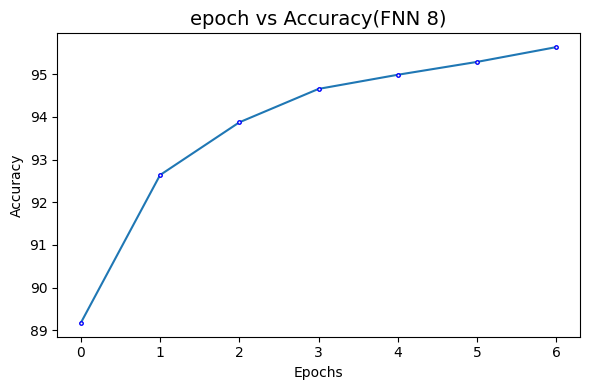

In [114]:
epochs = [ i for i in range(7)]
plot_accuracy(epochs,accuracies_8,'FNN 8')

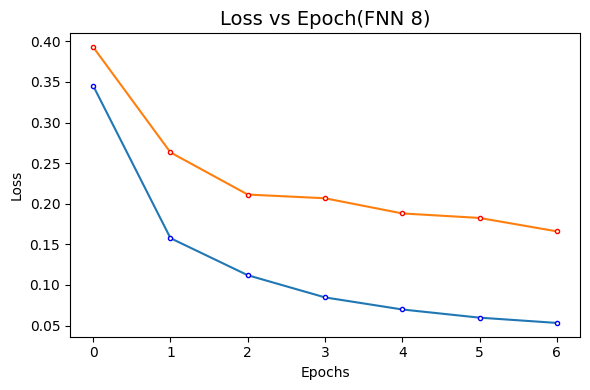

In [115]:
epochs = [ i for i in range(7)]
plot_loss(epochs,train_loss_8,test_loss_8,'FNN 8')

Accuracy: 0.9563384522734116
Recall (micro): 0.9563384522734116
F1 Score (micro): 0.9563384522734116
F1 Score (macro): 0.9209797680652171


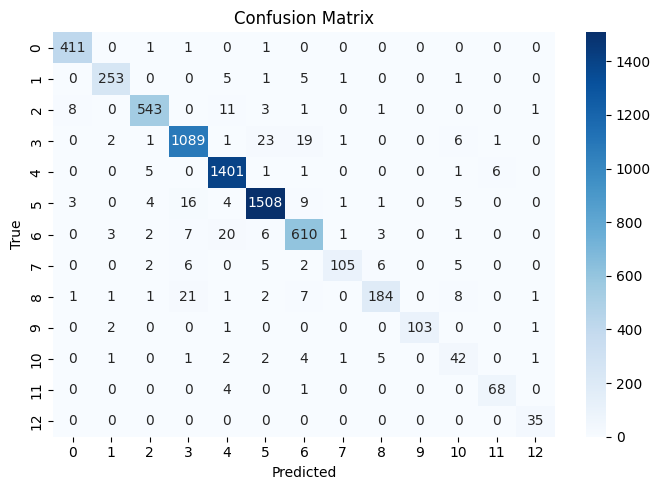

In [118]:
actual_label, pred_label = tets_on(dev_data,dev_label,model3,batch_size,word_to_ix,tag_to_ix)
evaluate_classification(actual_label, pred_label)

Accuracy: 0.9586626139817629
Recall (micro): 0.9586626139817629
F1 Score (micro): 0.9586626139817629
F1 Score (macro): 0.9268787156695731


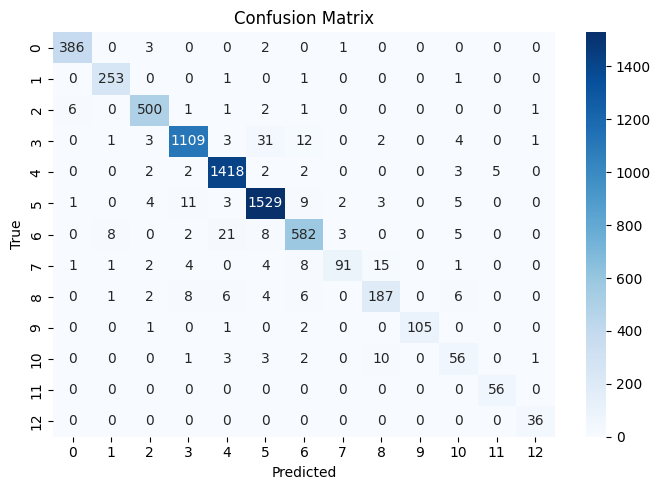

In [119]:
actual_label, pred_label = tets_on(test_data,test_label,model3,batch_size,word_to_ix,tag_to_ix)
evaluate_classification(actual_label, pred_label)

In [ ]:
torch.save(model3.state_dict(), '/content/drive/MyDrive/IIIT/SEM 4/NLP/A2/dataset/english/models/fnn_config_8.pth')

## tanh


In [ ]:
class SimpleMLEModeltanh(nn.Module):
    def __init__(self, vocab_size, tagset_size,sen_size, embedding_dim, hidden_dim):
        super(SimpleMLEModeltanh, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.hidden_dim = hidden_dim
        self.linear1 = nn.Linear(embedding_dim*sen_size, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, tagset_size)
        self.tanh = nn.Tanh()

    def forward(self, sentence):
      embeds = self.embedding(sentence)
      embeds = torch.flatten(embeds, start_dim=1)
      # print(embeds.shape)
      out = self.linear1(embeds)
      out = self.tanh(out)
      out = self.linear2(out)
      return out

In [ ]:
vocab_size = len(word_to_ix)
tagset_size = len(tag_to_ix)
embedding_dim = 25
hidden_dim = 25
learning_rate = 0.1
epochs = 10
batch_size = 1

In [ ]:
model3 = SimpleMLEModeltanh(vocab_size,tagset_size,n+p+1, embedding_dim, hidden_dim)

loss_function = nn.CrossEntropyLoss()
optimizer = optim.SGD(model3.parameters(), lr=learning_rate)

In [ ]:
train_loss_8,test_loss_8,accuracies_8, model3 = train_the_model(model3, loss_function, optimizer,train_data,train_label,word_to_ix,tag_to_ix,dev_data,dev_label,10 )

1 0.4167908532453472 0.5164395801487264 88.69316470942488
2 0.21650062581503982 0.35310981005709047 91.43330322192111
3 0.16771204571954423 0.29953436763828994 92.81842818428184
4 0.14525848479063708 0.28908860704625633 93.5862691960253
5 0.1482612672782272 0.26736996137049596 93.3152664859982
6 0.14113394421316372 0.2593964293522241 93.76693766937669
7 0.13225598311486095 0.23789877757799505 94.11321890996688
8 0.12224054588977437 0.20820325193755185 94.71544715447155
9 0.11271448675549704 0.20878812791069304 94.8509485094851
10 0.11491129509528271 0.21734839913404905 94.83589280337247


In [ ]:
accuracies_8

[88.69316470942488,
 91.43330322192111,
 92.81842818428184,
 93.5862691960253,
 93.3152664859982,
 93.76693766937669,
 94.11321890996688,
 94.71544715447155,
 94.8509485094851,
 94.83589280337247]

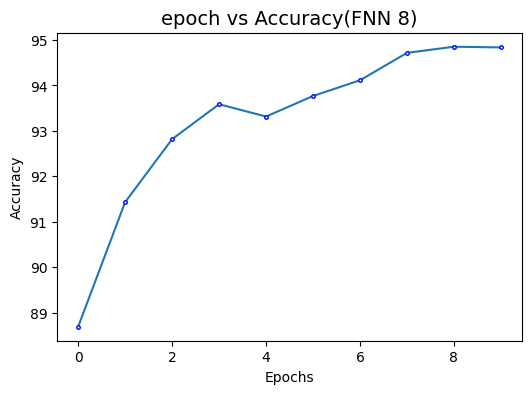

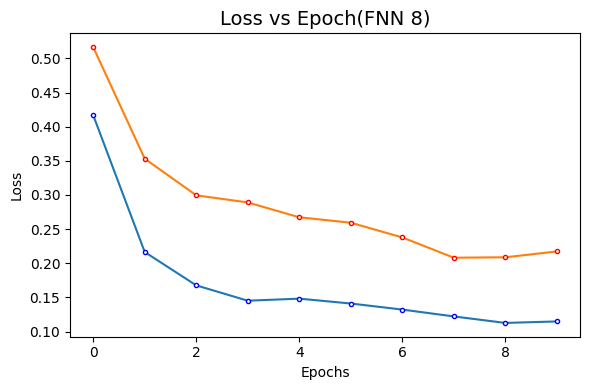

In [ ]:
epochs = [ i for i in range(10)]
plot_accuracy(epochs,accuracies_8,'FNN 8')
plt.show()

plot_loss(epochs,train_loss_8,test_loss_8,'FNN 8')

Accuracy: 0.9483589280337248
Recall (micro): 0.9483589280337248
F1 Score (micro): 0.9483589280337248
F1 Score (macro): 0.8933870614243996


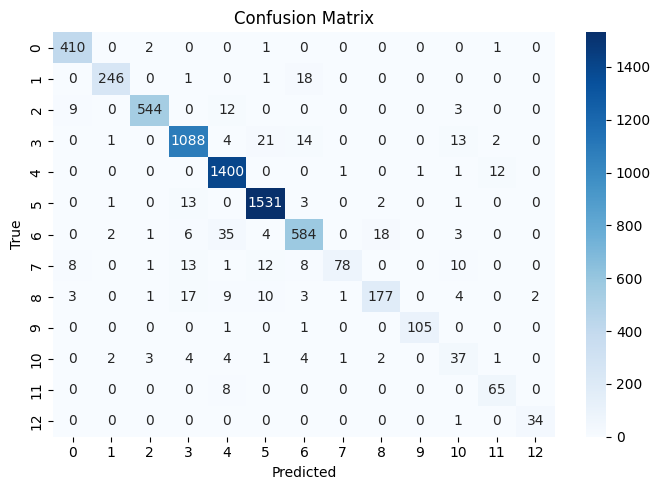

In [ ]:
actual_label, pred_label = tets_on(dev_data,dev_label,model3,batch_size,word_to_ix,tag_to_ix)
evaluate_classification(actual_label, pred_label)

Accuracy: 0.9501519756838905
Recall (micro): 0.9501519756838905
F1 Score (micro): 0.9501519756838905
F1 Score (macro): 0.8984601365732543


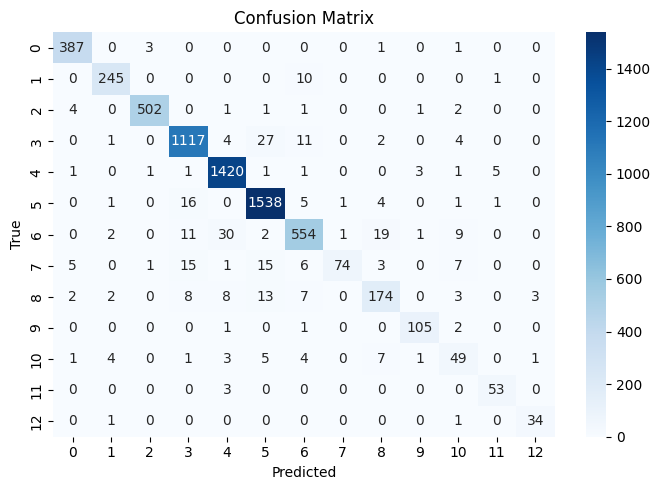

In [ ]:
actual_label, pred_label = tets_on(test_data,test_label,model3,batch_size,word_to_ix,tag_to_ix)
evaluate_classification(actual_label, pred_label)

In [ ]:
torch.save(model3.state_dict(), '/content/drive/MyDrive/IIIT/SEM 4/NLP/A2/dataset/english/models/fnn_tanh_1.pth')

# N = 0 ans  P = 0

In [43]:
n=0
p=0

In [44]:
train_data = prepare_windows(train_s,n,p)
dev_data = prepare_windows(dev_s,n,p)
test_data = prepare_windows(test_s,n,p)

In [45]:
vocab_size = len(word_to_ix)
tagset_size = len(tag_to_ix)
embedding_dim = 25
hidden_dim = 25
learning_rate = 0.01
epochs = 10
batch_size = 1

In [46]:
model3 = SimpleMLEModel(vocab_size,tagset_size,n+p+1, embedding_dim, hidden_dim)

loss_function = nn.CrossEntropyLoss()
optimizer = optim.SGD(model3.parameters(), lr=learning_rate)

In [47]:
train_loss_8,test_loss_8,accuracies_8, model3 = train_the_model(model3, loss_function, optimizer,train_data,train_label,word_to_ix,tag_to_ix,dev_data,dev_label,10 )

1 0.38118713639212526 0.36626942103730875 87.35320686540199
2 0.1842042680957953 0.25818104418978377 90.8762420957543
3 0.14581711053778665 0.21078159600244958 93.08943089430895
4 0.12663529543472862 0.18448322549090573 93.43571213489912
5 0.11562674362763414 0.17865543676078322 92.53236976814213
6 0.10893444468643572 0.1713833287066936 92.65281541704306
7 0.10461539817682539 0.16711395417960598 92.6829268292683
8 0.10183180553202416 0.1635209049828043 92.74314965371876
9 0.09934678779451607 0.16224338643251227 92.83348389039446
10 0.09766667666254712 0.15969542794011266 92.89370671484492


In [48]:
accuracies_8

[87.35320686540199,
 90.8762420957543,
 93.08943089430895,
 93.43571213489912,
 92.53236976814213,
 92.65281541704306,
 92.6829268292683,
 92.74314965371876,
 92.83348389039446,
 92.89370671484492]

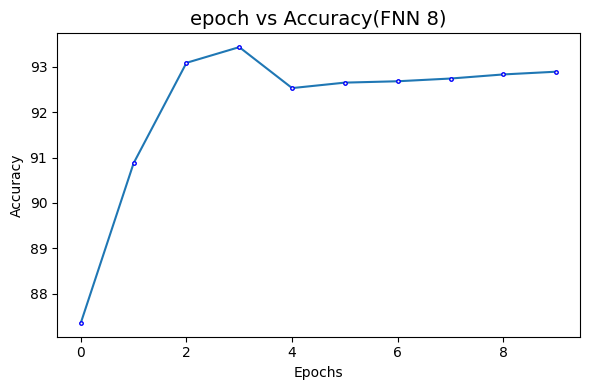

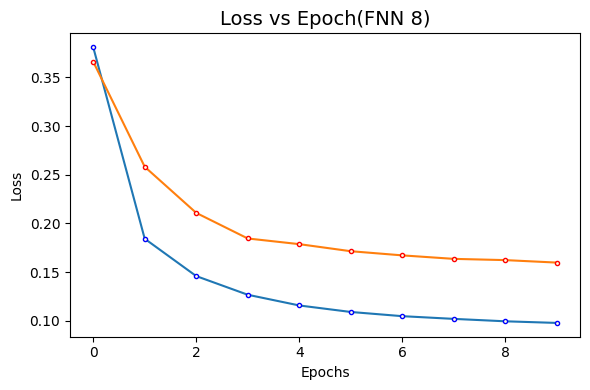

In [49]:
epochs = [ i for i in range(10)]
plot_accuracy(epochs,accuracies_8,'FNN 8')
plt.show()

plot_loss(epochs,train_loss_8,test_loss_8,'FNN 8')

Accuracy: 0.9289370671484493
Recall (micro): 0.9289370671484493
F1 Score (micro): 0.9289370671484493
F1 Score (macro): 0.853021034576875


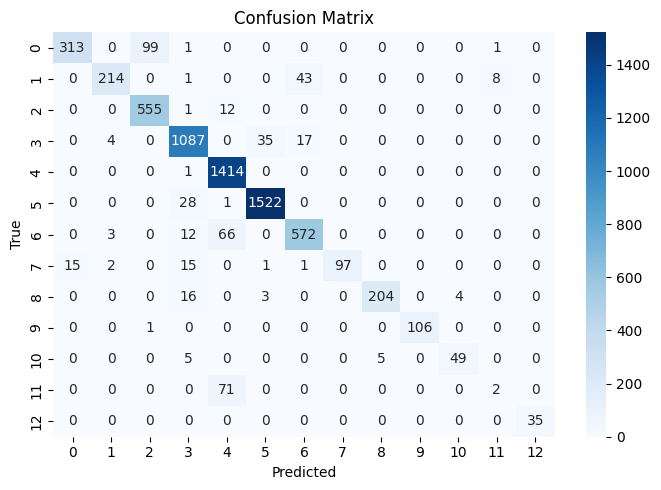

In [50]:
actual_label, pred_label = tets_on(dev_data,dev_label,model3,batch_size,word_to_ix,tag_to_ix)
evaluate_classification(actual_label, pred_label)

Accuracy: 0.9249240121580548
Recall (micro): 0.9249240121580548
F1 Score (micro): 0.9249240121580548
F1 Score (macro): 0.8298528106098898


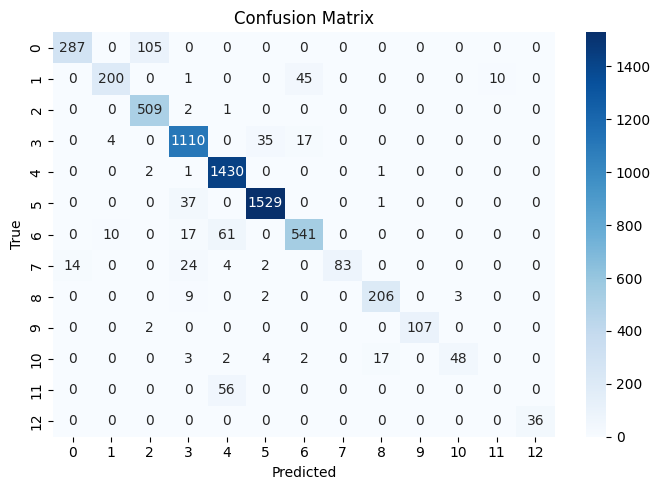

In [51]:
actual_label, pred_label = tets_on(test_data,test_label,model3,batch_size,word_to_ix,tag_to_ix)
evaluate_classification(actual_label, pred_label)

In [52]:
torch.save(model3.state_dict(), '/content/drive/MyDrive/IIIT/SEM 4/NLP/A2/dataset/english/models/fnn_window_new0.pth')

# N = 1 ans  P = 1

In [53]:
n=1
p=1

In [54]:
train_data = prepare_windows(train_s,n,p)
dev_data = prepare_windows(dev_s,n,p)
test_data = prepare_windows(test_s,n,p)

In [55]:
vocab_size = len(word_to_ix)
tagset_size = len(tag_to_ix)
embedding_dim = 25
hidden_dim = 25
learning_rate = 0.01
epochs = 10
batch_size = 1

In [56]:
model3 = SimpleMLEModel(vocab_size,tagset_size,n+p+1, embedding_dim, hidden_dim)

loss_function = nn.CrossEntropyLoss()
optimizer = optim.SGD(model3.parameters(), lr=learning_rate)

In [57]:
train_loss_8,test_loss_8,accuracies_8, model3 = train_the_model(model3, loss_function, optimizer,train_data,train_label,word_to_ix,tag_to_ix,dev_data,dev_label,10 )

1 0.3284304321245344 0.37736477161407583 88.76844323998796
2 0.15175707909097094 0.25906997057927544 92.24631135200241
3 0.10932215408630902 0.19240915287445468 93.96266184884071
4 0.08736100753764359 0.16148266150598856 94.8509485094851
5 0.07285770762029968 0.14504964532834144 95.57362240289069
6 0.06259320082773964 0.13432927201652042 96.1306835290575
7 0.05585755804568693 0.12899392024896583 96.25112917795845
8 0.05008836764883181 0.12503864931230083 96.40168623908461
9 0.0457281593148604 0.12652440673076212 96.4769647696477
10 0.04208368363184832 0.12865531623113005 96.49202047576031


In [58]:
accuracies_8

[88.76844323998796,
 92.24631135200241,
 93.96266184884071,
 94.8509485094851,
 95.57362240289069,
 96.1306835290575,
 96.25112917795845,
 96.40168623908461,
 96.4769647696477,
 96.49202047576031]

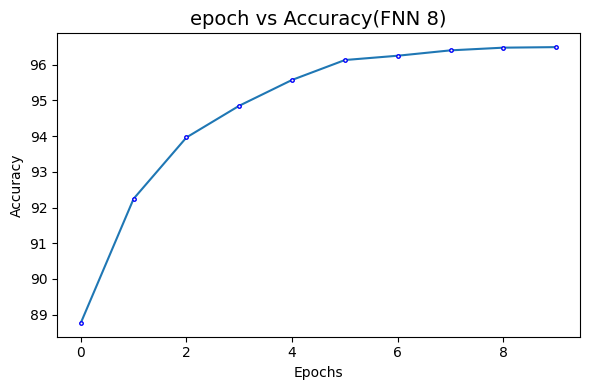

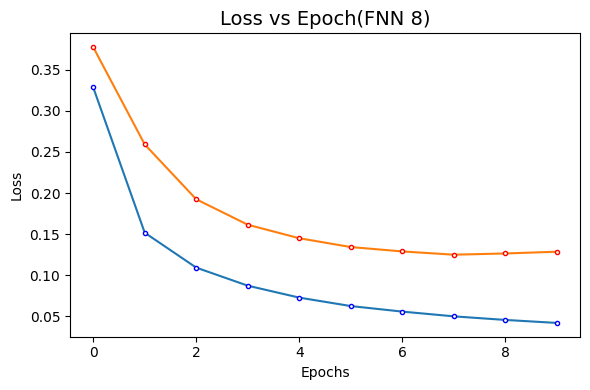

In [59]:
epochs = [ i for i in range(10)]
plot_accuracy(epochs,accuracies_8,'FNN 8')
plt.show()

plot_loss(epochs,train_loss_8,test_loss_8,'FNN 8')

Accuracy: 0.9649202047576031
Recall (micro): 0.9649202047576031
F1 Score (micro): 0.9649202047576031
F1 Score (macro): 0.9498869264899954


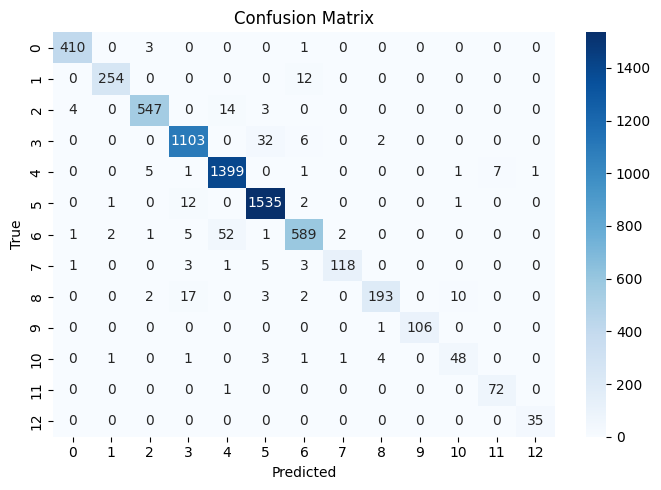

In [60]:
actual_label, pred_label = tets_on(dev_data,dev_label,model3,batch_size,word_to_ix,tag_to_ix)
evaluate_classification(actual_label, pred_label)

Accuracy: 0.9648936170212766
Recall (micro): 0.9648936170212766
F1 Score (micro): 0.9648936170212766
F1 Score (macro): 0.9457098779188464


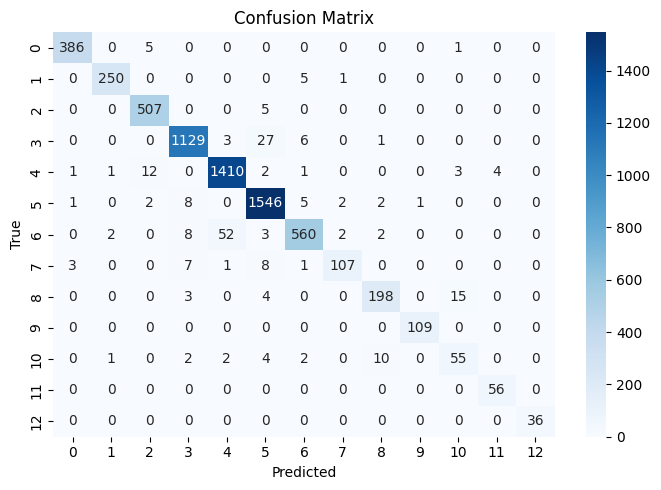

In [61]:
actual_label, pred_label = tets_on(test_data,test_label,model3,batch_size,word_to_ix,tag_to_ix)
evaluate_classification(actual_label, pred_label)

In [62]:
torch.save(model3.state_dict(), '/content/drive/MyDrive/IIIT/SEM 4/NLP/A2/dataset/english/models/fnn_window_new1.pth')

# N = 2 ans  P = 2

In [63]:
n=2
p=2

In [64]:
train_data = prepare_windows(train_s,n,p)
dev_data = prepare_windows(dev_s,n,p)
test_data = prepare_windows(test_s,n,p)

In [65]:
vocab_size = len(word_to_ix)
tagset_size = len(tag_to_ix)
embedding_dim = 25
hidden_dim = 25
learning_rate = 0.01
epochs = 10
batch_size = 1

In [66]:
model3 = SimpleMLEModel(vocab_size,tagset_size,n+p+1, embedding_dim, hidden_dim)

loss_function = nn.CrossEntropyLoss()
optimizer = optim.SGD(model3.parameters(), lr=learning_rate)

In [67]:
train_loss_8,test_loss_8,accuracies_8, model3 = train_the_model(model3, loss_function, optimizer,train_data,train_label,word_to_ix,tag_to_ix,dev_data,dev_label,10 )

1 0.33508273704748137 0.3714863194103941 89.49111713339356
2 0.16744240582361572 0.27617086742801134 92.14092140921409
3 0.12314527747316843 0.233637712478493 93.45076784101174
4 0.09770396876623039 0.21183312645332633 94.3089430894309
5 0.08005252576264768 0.19420328377904925 94.67028003613369
6 0.06842822495954608 0.18031017537405866 95.22734116230052
7 0.0583192028091148 0.17643257445760577 95.28756398675098
8 0.05092937292303725 0.17559370976115093 95.61878952122855
9 0.04451774273895407 0.1685379730411325 95.78440228846733
10 0.039491319800457565 0.17183971584668284 95.6639566395664


In [68]:
accuracies_8

[89.49111713339356,
 92.14092140921409,
 93.45076784101174,
 94.3089430894309,
 94.67028003613369,
 95.22734116230052,
 95.28756398675098,
 95.61878952122855,
 95.78440228846733,
 95.6639566395664]

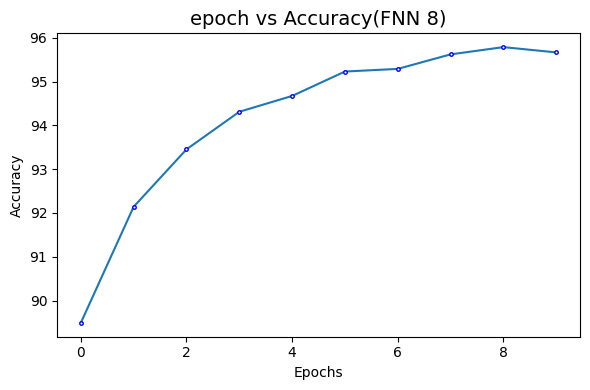

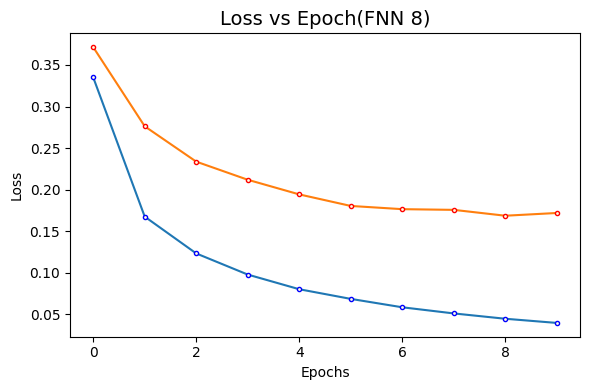

In [69]:
epochs = [ i for i in range(10)]
plot_accuracy(epochs,accuracies_8,'FNN 8')
plt.show()

plot_loss(epochs,train_loss_8,test_loss_8,'FNN 8')

Accuracy: 0.9566395663956639
Recall (micro): 0.9566395663956639
F1 Score (micro): 0.9566395663956639
F1 Score (macro): 0.9297079787951064


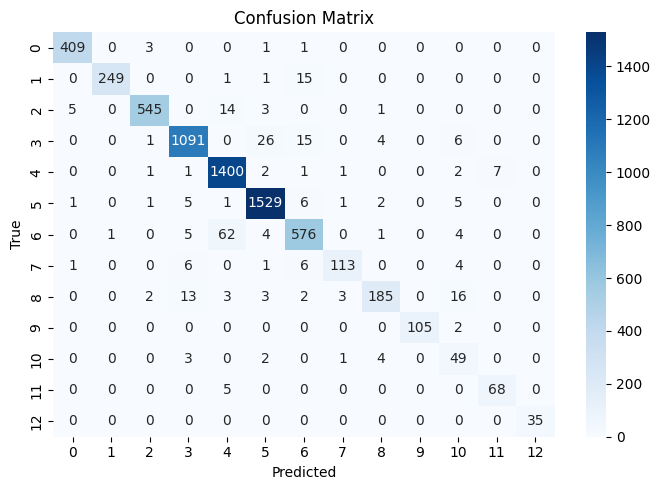

In [70]:
actual_label, pred_label = tets_on(dev_data,dev_label,model3,batch_size,word_to_ix,tag_to_ix)
evaluate_classification(actual_label, pred_label)

Accuracy: 0.9582066869300911
Recall (micro): 0.9582066869300911
F1 Score (micro): 0.9582066869300911
F1 Score (macro): 0.9308397229096852


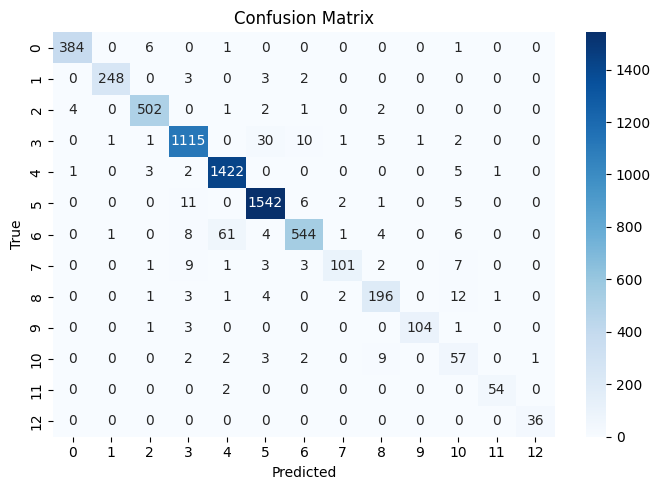

In [71]:
actual_label, pred_label = tets_on(test_data,test_label,model3,batch_size,word_to_ix,tag_to_ix)
evaluate_classification(actual_label, pred_label)

In [72]:
torch.save(model3.state_dict(), '/content/drive/MyDrive/IIIT/SEM 4/NLP/A2/dataset/english/models/fnn_window_new2.pth')

# N = 3 ans  P = 3

In [73]:
n=3
p=3

In [74]:
train_data = prepare_windows(train_s,n,p)
dev_data = prepare_windows(dev_s,n,p)
test_data = prepare_windows(test_s,n,p)

In [75]:
vocab_size = len(word_to_ix)
tagset_size = len(tag_to_ix)
embedding_dim = 25
hidden_dim = 25
learning_rate = 0.01
epochs = 10
batch_size = 1

In [76]:
model3 = SimpleMLEModel(vocab_size,tagset_size,n+p+1, embedding_dim, hidden_dim)

loss_function = nn.CrossEntropyLoss()
optimizer = optim.SGD(model3.parameters(), lr=learning_rate)

In [77]:
train_loss_8,test_loss_8,accuracies_8, model3 = train_the_model(model3, loss_function, optimizer,train_data,train_label,word_to_ix,tag_to_ix,dev_data,dev_label,10 )

1 0.35212754608122887 0.410357936878961 88.27160493827161
2 0.1775257239388945 0.2928561955890823 91.6892502258356
3 0.12636348865470365 0.2534783298416178 93.39054501656128
4 0.09841841536981828 0.2229631065502339 94.05299608551641
5 0.07901164695486217 0.2036067539126531 94.73050286058417
6 0.06603250048236212 0.19294381939003022 94.9412827461608
7 0.055692209648279506 0.1928203954736131 95.16711833785004
8 0.04780101084079086 0.1894053928373306 95.36284251731406
9 0.04158375649053499 0.1890888796597046 95.52845528455285
10 0.038143268932047614 0.1968486754159008 95.33273110508883


In [78]:
accuracies_8

[88.27160493827161,
 91.6892502258356,
 93.39054501656128,
 94.05299608551641,
 94.73050286058417,
 94.9412827461608,
 95.16711833785004,
 95.36284251731406,
 95.52845528455285,
 95.33273110508883]

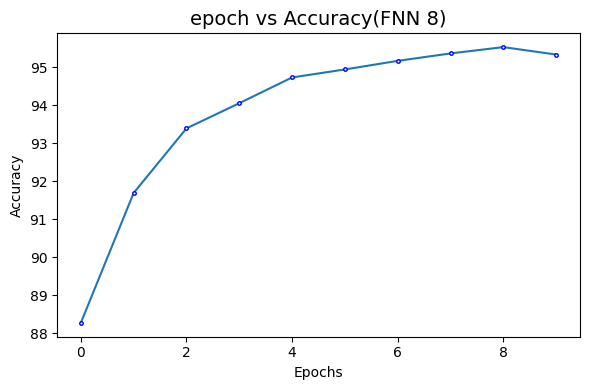

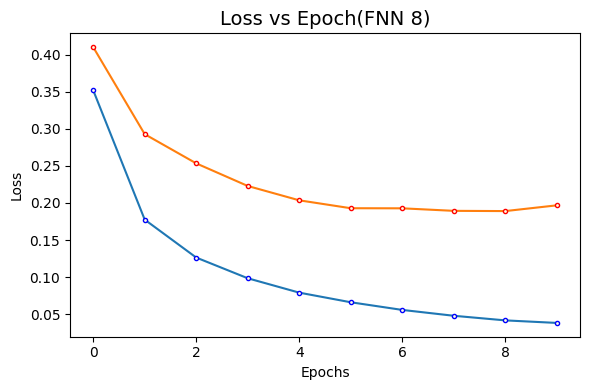

In [79]:
epochs = [ i for i in range(10)]
plot_accuracy(epochs,accuracies_8,'FNN 8')
plt.show()

plot_loss(epochs,train_loss_8,test_loss_8,'FNN 8')

Accuracy: 0.9533273110508883
Recall (micro): 0.9533273110508883
F1 Score (micro): 0.9533273110508883
F1 Score (macro): 0.9171764498115329


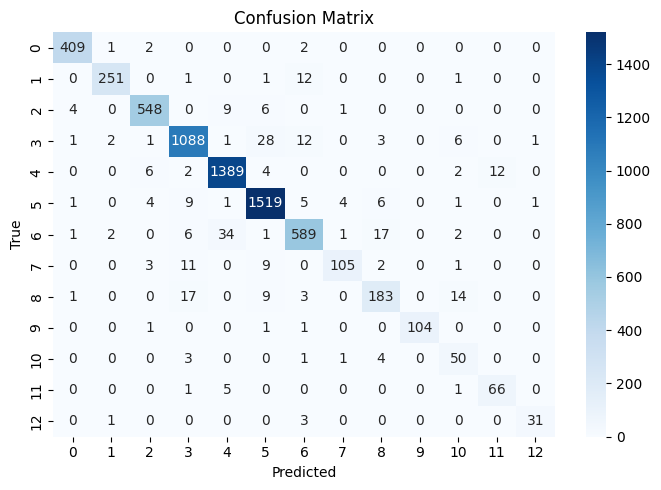

In [80]:
actual_label, pred_label = tets_on(dev_data,dev_label,model3,batch_size,word_to_ix,tag_to_ix)
evaluate_classification(actual_label, pred_label)

Accuracy: 0.9580547112462006
Recall (micro): 0.9580547112462006
F1 Score (micro): 0.9580547112462006
F1 Score (macro): 0.9316682251599857


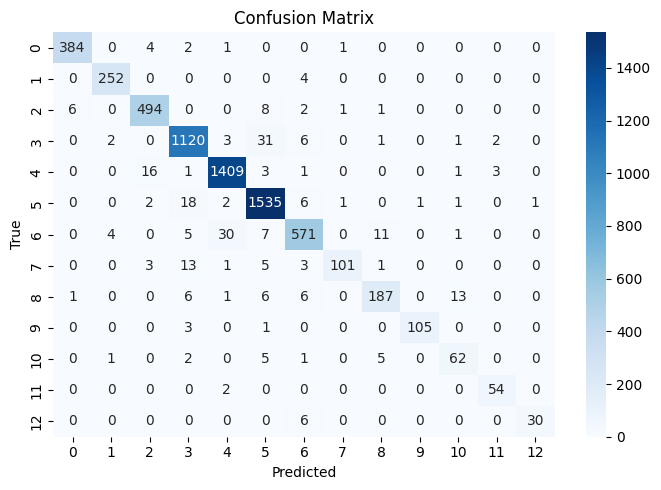

In [81]:
actual_label, pred_label = tets_on(test_data,test_label,model3,batch_size,word_to_ix,tag_to_ix)
evaluate_classification(actual_label, pred_label)

In [82]:
torch.save(model3.state_dict(), '/content/drive/MyDrive/IIIT/SEM 4/NLP/A2/dataset/english/models/fnn_window_new3.pth')

# N = 4 ans  P = 4

In [83]:
n=4
p=4

In [84]:
train_data = prepare_windows(train_s,n,p)
dev_data = prepare_windows(dev_s,n,p)
test_data = prepare_windows(test_s,n,p)

In [85]:
vocab_size = len(word_to_ix)
tagset_size = len(tag_to_ix)
embedding_dim = 25
hidden_dim = 25
learning_rate = 0.01
epochs = 10
batch_size = 1

In [86]:
model3 = SimpleMLEModel(vocab_size,tagset_size,n+p+1, embedding_dim, hidden_dim)

loss_function = nn.CrossEntropyLoss()
optimizer = optim.SGD(model3.parameters(), lr=learning_rate)

In [87]:
train_loss_8,test_loss_8,accuracies_8, model3 = train_the_model(model3, loss_function, optimizer,train_data,train_label,word_to_ix,tag_to_ix,dev_data,dev_label,10 )

1 0.3620854182705833 0.4214769007103783 88.57271906052394
2 0.17824644098674233 0.30011698987921015 91.70430593194821
3 0.12854991071876615 0.2398327334863263 93.07437518819633
4 0.0996060597772847 0.21809141426490145 93.99277326106595
5 0.080341311671525 0.20862898141714156 94.53477868112014
6 0.06495783431741872 0.19614398790099744 94.89611562782295
7 0.056091895130945923 0.19910589465713244 95.16711833785004
8 0.04614018469409147 0.20803554018593967 94.98644986449864
9 0.03959935275589012 0.1940617458372955 95.45317675398977
10 0.035662975969028836 0.19306559329370454 95.39295392953929


In [88]:
accuracies_8

[88.57271906052394,
 91.70430593194821,
 93.07437518819633,
 93.99277326106595,
 94.53477868112014,
 94.89611562782295,
 95.16711833785004,
 94.98644986449864,
 95.45317675398977,
 95.39295392953929]

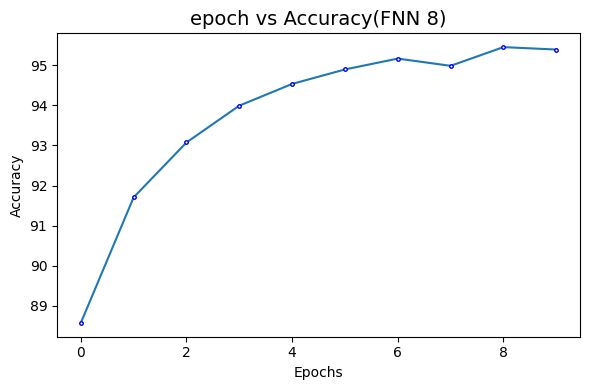

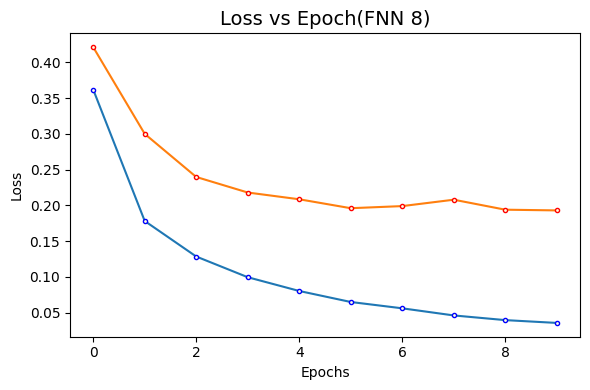

In [89]:
epochs = [ i for i in range(10)]
plot_accuracy(epochs,accuracies_8,'FNN 8')
plt.show()

plot_loss(epochs,train_loss_8,test_loss_8,'FNN 8')

Accuracy: 0.9539295392953929
Recall (micro): 0.9539295392953929
F1 Score (micro): 0.9539295392953929
F1 Score (macro): 0.912748095978223


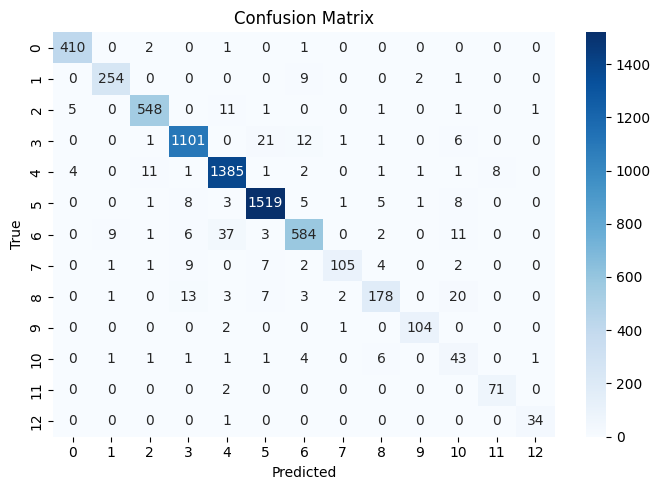

In [90]:
actual_label, pred_label = tets_on(dev_data,dev_label,model3,batch_size,word_to_ix,tag_to_ix)
evaluate_classification(actual_label, pred_label)

Accuracy: 0.9566869300911854
Recall (micro): 0.9566869300911854
F1 Score (micro): 0.9566869300911854
F1 Score (macro): 0.9150190642611826


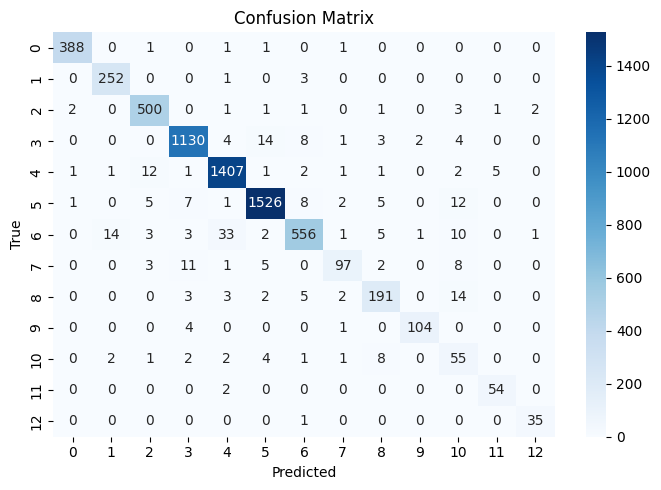

In [91]:
actual_label, pred_label = tets_on(test_data,test_label,model3,batch_size,word_to_ix,tag_to_ix)
evaluate_classification(actual_label, pred_label)

In [92]:
torch.save(model3.state_dict(), '/content/drive/MyDrive/IIIT/SEM 4/NLP/A2/dataset/english/models/fnn_window_new4.pth')

# Graphs


In [93]:
windows = [i for i in range(5)]
dev_acc = [0.9289370671484493,0.9649202047576031, 0.9566395663956639,0.9533273110508883,  0.9539295392953929 ]
test_acc = [0.9249240121580548,0.9648936170212766,0.9582066869300911, 0.9580547112462006, 0.9566869300911854 ]

Text(0, 0.5, 'Accuracy')

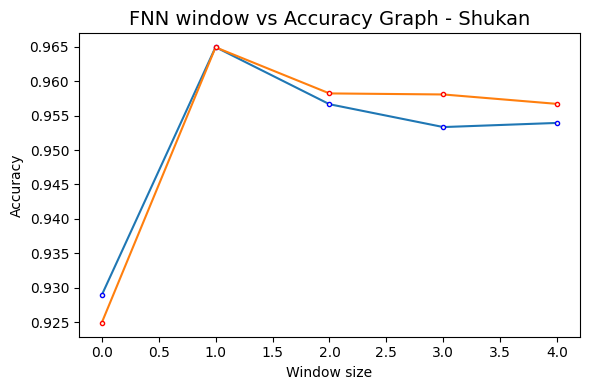

In [94]:
plt.rcParams["figure.figsize"] = [6, 4]
plt.rcParams["figure.autolayout"] = True
plt.plot(windows, dev_acc, marker=".", markeredgecolor="blue", markerfacecolor="lightyellow",label='line1')
plt.plot(windows, test_acc, marker=".", markeredgecolor="red", markerfacecolor="lightyellow",label='line2')
plt.title(f'FNN window vs Accuracy Graph - Shukan',fontsize=14)
plt.xlabel('Window size')
plt.ylabel('Accuracy')